In [ ]:
# Import modules
import pandas as pd
import scanpy as sc
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import scipy.sparse as sp
from tqdm.auto import tqdm
from scipy.stats.contingency import crosstab
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
adata = sc.read_h5ad('8_Classifiers/Data/Input/scAtlas_grouped.h5ad')
adata

AnnData object with n_obs × n_vars = 52997 × 45454
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'doublet_scores', 'predicted_doublets

In [ ]:
clf = joblib.load('8_Classifiers/Models/best_xgb_classifier.pkl')

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [4]:
# List of genes used for training
gene_names = ['C1QB', 'C1QA', 'FCER1A', 'CD1C', 'FCN1', 'VCAN', 'CPA3', 'TPSAB1', 'ICAM1', 'CXCR2']

# Make sure the genes exist in the dataset
missing_genes = [g for g in gene_names if g not in adata.var['feature_name']]
if missing_genes:
    raise ValueError(f"Missing genes in dataset: {missing_genes}")

# Subset adata to just the genes used for training, preserving order
X_subset = adata[:, gene_names].X

In [8]:
# Encode labels
le = LabelEncoder()
y_true_encoded = le.fit_transform(adata.obs['cell_type_group'])

In [9]:
adata.obs['predicted_cell_type_group'] = le.inverse_transform(clf.predict(X_subset))

In [ ]:
acc = accuracy_score(adata.obs['cell_type_group'], adata.obs['predicted_cell_type_group'])
f1 = f1_score(adata.obs['cell_type_group'], adata.obs['predicted_cell_type_group'], average='weighted')

#print(f"\nBest Params: {grid_search.best_params_}")
print(f"Accuracy on test set: {acc:.3f}")
print(f"F1 score on test set: {f1:.3f}")
print('\nClassification Report:\n', classification_report(adata.obs['cell_type_group'], adata.obs['predicted_cell_type_group']))

Accuracy on test set: 0.665
F1 score on test set: 0.532


/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

         DCs       0.00      0.00      0.00      6212
 Macrophages       0.67      1.00      0.80     35257
   Monocytes       0.00      0.00      0.00     10167
        Rest       0.00      0.00      0.00      1361

    accuracy                           0.67     52997
   macro avg       0.17      0.25      0.20     52997
weighted avg       0.44      0.67      0.53     52997



/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

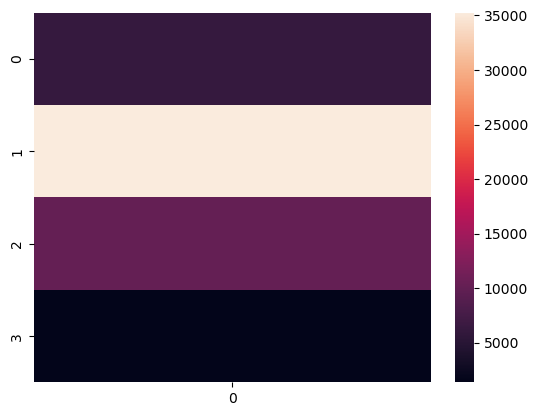

In [11]:
sns.heatmap(crosstab(list(adata.obs['cell_type_group'].values), list(adata.obs['predicted_cell_type_group'].values)).count)

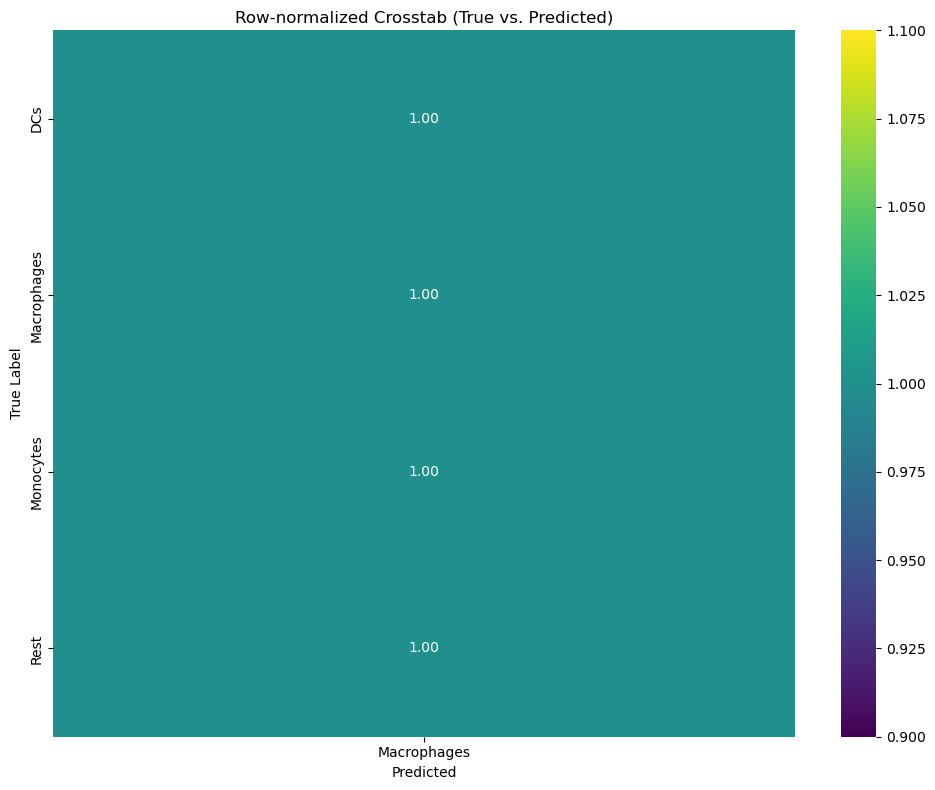

In [ ]:
# Row normalize the true labels to show the performance of classification for each class
ct_normalized = pd.crosstab(adata.obs['cell_type_group'], adata.obs['predicted_cell_type_group'], normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(ct_normalized, cmap='viridis', annot=True, fmt='.2f')
plt.title('Row-normalized Crosstab (True vs. Predicted)')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()